<h1> CLASSIFICATORE NAIVE BAYES: titleType </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [3]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

<h2>Caricamento train set e test set</h2>

In [4]:
df_tra= pd.read_csv('df_train.csv',  skipinitialspace=True)
df_tes= pd.read_csv('df_test.csv', skipinitialspace=True)

In [5]:
rating_mapping = {
    '(0, 1]': 1,
    '(1, 2]': 2,
    '(2, 3]': 3,
    '(3, 4]': 4,
    '(4, 5]': 5,
    '(5, 6]': 6,
    '(6, 7]': 7,
    '(7, 8]': 8,
    '(8, 9]': 9,
    '(9, 10]': 10
}

df_tes['rating'] = df_tes['rating'].map(rating_mapping)

df_tes['canHaveEpisodes'] = df_tes['canHaveEpisodes'].astype(int)

In [6]:
# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = df_tes['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = df_tes['countryOfOrigin'].apply(lambda x: eval(x) if isinstance(x, str) else [])  # Trasforma la stringa in una lista
df_country = df_country.explode()  # Esplode la lista di paesi
df_country_encoded = pd.get_dummies(df_country, prefix='country')  # Crea One-Hot Encoding per ogni paese

# Raggruppa e somma per tornare alla struttura originale
df_country_encoded = df_country_encoded.groupby(df_country.index).sum()



# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([df_tes, df_genres, df_country_encoded], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin'])

# Visualizza i primi 5 record del dataframe trasformato
df_tes = df_encoded.copy()
df_tes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Columns: 157 entries, rating to country_ZA
dtypes: float64(2), int64(154), object(1)
memory usage: 6.5+ MB


In [7]:
# 1. One-Hot Encoding della variabile 'genres' (attento: può essere più complesso perché è una lista di generi)
df_genres = df_tra['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])  # Splitta i generi in una lista
df_genres = df_genres.explode().str.get_dummies().groupby(level=0).sum()  # Crea una colonna per ogni genere

# 2. One-Hot Encoding della variabile 'countryOfOrigin'
df_country = df_tra['countryOfOrigin'].apply(lambda x: eval(x) if isinstance(x, str) else [])  # Trasforma la stringa in una lista
df_country = df_country.explode()  # Esplode la lista di paesi
df_country_encoded = pd.get_dummies(df_country, prefix='country')  # Crea One-Hot Encoding per ogni paese

# Raggruppa e somma per tornare alla struttura originale
df_country_encoded = df_country_encoded.groupby(df_country.index).sum()



# 4. Concatenare i dati trasformati con il dataframe originale
df_encoded = pd.concat([df_tra, df_genres, df_country_encoded], axis=1)

# Ora df_encoded contiene le variabili originali e le variabili One-Hot Encoded
# Rimuoviamo le colonne originali non necessarie (se vuoi)
df_encoded = df_encoded.drop(columns=['genres', 'countryOfOrigin'])

# Visualizza i primi 5 record del dataframe trasformato
df_tra = df_encoded.copy()
df_tra.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16416 entries, 0 to 16415
Columns: 196 entries, rating to country_ZW
dtypes: int64(196)
memory usage: 24.5 MB


In [8]:
# Lista dei valori unici in 'titleType'
unique_title_types = ['tvEpisode', 'videoGame', 'movie', 'tvSeries', 'video', 'tvMiniSeries', 'short', 'tvMovie', 'tvSpecial', 'tvShort']

# Crea un dizionario di mappatura che assegna un numero a ciascun tipo
title_type_mapping = {title: i + 1 for i, title in enumerate(unique_title_types)}

# Crea una mappatura inversa che assegna il numero alla stringa
reverse_title_type_mapping = {v: k for k, v in title_type_mapping.items()}

# Ora riconverti i numeri nel DataFrame df1 in stringhe
df_tra['titleType'] = df_tra['titleType'].map(reverse_title_type_mapping)

# Verifica il risultato
print(df_tra['titleType'].head(10))

0       tvEpisode
1       videoGame
2           movie
3        tvSeries
4        tvSeries
5           video
6       tvEpisode
7    tvMiniSeries
8           short
9    tvMiniSeries
Name: titleType, dtype: object


In [9]:
no_coun_train=0
for c in df_tra.columns:
    #print(c)
    no_coun_train+=1
no_coun_test=0
for c in df_tes.columns:
    #print(c)
    no_coun_test+=1
print(no_coun_test, no_coun_train)

157 196


In [10]:
df_tes = df_tes.reindex(columns=df_tra.columns, fill_value=0)
print("clean_train shape:", df_tra.shape)
print("clean_test shape:", df_tes.shape)

clean_train shape: (16416, 196)
clean_test shape: (5460, 196)


In [11]:
df_train = df_tra.copy()
df_test = df_tes.copy()

<h1>VALUTAZIONE SUL TEST SET</h1> 

<h2>GAUSSIAN NB</h2>

In [12]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# 1. Selezioniamo le variabili numeriche
non_cat_columns = [
    "startYear", "runtimeMinutes", "awardWins", "totalImages", "totalVideos", 
    "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", 
    "userReviewsTotal", "ratingCount", "numRegions"
]

# 2. Preprocessing dei dati di addestramento (df_train)
X_train_noncat = df_train[non_cat_columns].values  # Usa df_train

# Codifica del target 'titleType' (etichetta categorica)
label_encoder = LabelEncoder()
y_train_noncat = label_encoder.fit_transform(df_train['titleType'])  # 'titleType' è il target ora

# 3. Creazione del modello Naive Bayes
nbg = GaussianNB()
nbg.fit(X_train_noncat, y_train_noncat)

# 4. **Test sul Test Set (df_test)**

# Selezioniamo le stesse feature numeriche per il test set
X_test_gauss = df_test[non_cat_columns].values  # Usa df_test

# Codifica anche le etichette del test set
y_test_gauss = label_encoder.transform(df_test['titleType'])  # Codifica 'titleType' come nel training

# Fare predizioni sul test set
y_pred_test = nbg.predict(X_test_gauss)

# 5. Report di classificazione sul Test Set
print("Classification Report sul Test Set:")
print(classification_report(y_test_gauss, y_pred_test))

# Calcolare ROC AUC (multi-class) sul test set
print("ROC AUC score sul Test Set:", roc_auc_score(y_test_gauss, nbg.predict_proba(X_test_gauss), multi_class="ovr", average="micro"))


Classification Report sul Test Set:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      1870
           1       0.27      0.64      0.38       766
           2       0.50      0.60      0.55      1599
           3       0.11      0.14      0.12        80
           4       0.10      0.14      0.12       299
           5       0.50      0.11      0.17       437
           6       0.03      0.50      0.05        16
           7       0.03      0.14      0.04        49
           8       0.20      0.14      0.17       250
           9       0.23      0.07      0.11        94

    accuracy                           0.35      5460
   macro avg       0.28      0.26      0.20      5460
weighted avg       0.55      0.35      0.34      5460

ROC AUC score sul Test Set: 0.7188102095977554


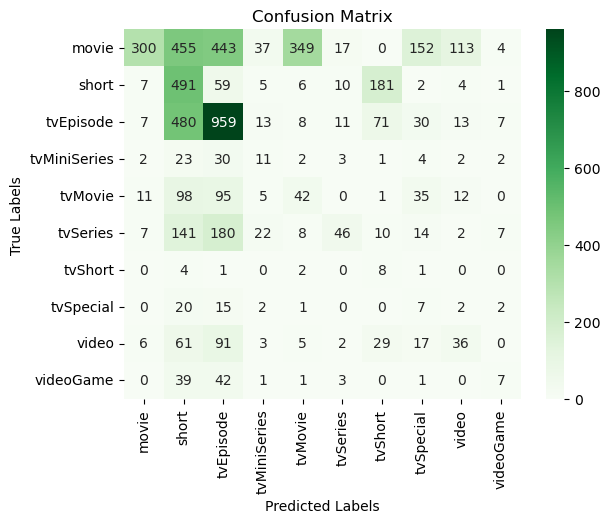

In [13]:
cm = confusion_matrix(y_test_gauss, y_pred_test)

# 7. Visualizzazione della Confusion Matrix

sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
#plt.savefig('gaussian_titleType.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>CATEGORICAL NB</h2>

In [14]:

# 1. Selezioniamo le variabili numeriche
non_cat_columns = [
    "startYear", "runtimeMinutes", "awardWins", "totalImages", "totalVideos", 
    "totalCredits", "criticReviewsTotal", "awardNominationsExcludeWins", 
    "userReviewsTotal", "ratingCount", "numRegions"
]

# Selezioniamo le feature numeriche dal training set
X_train_noncat = df_train[non_cat_columns].values

# 2. Codifica del target 'titleType' (etichetta categorica)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['titleType'])  # Codifica 'titleType' nel training set

# 3. Discretizzazione delle variabili numeriche nel training set
def discretize_column(X, num_categories=3):
    """Funzione per discretizzare una colonna in categorie numeriche"""
    X_cat = []
    
    for col_idx in range(X.shape[1]):
        # Verifica quante categorie uniche ci sono nella colonna
        unique_vals = np.unique(X[:, col_idx])
        # Riduci il numero di categorie se necessario
        n_categories = min(len(unique_vals), num_categories)
        # Discretizza la colonna in base al numero di categorie disponibili
        X_cat.append(pd.qcut(X[:, col_idx], q=n_categories, labels=False, duplicates='drop'))
    
    return np.array(X_cat).T

# Discretizza il set di addestramento
X_train_cat = discretize_column(X_train_noncat, num_categories=3)

# 4. Creazione del modello Naive Bayes categorico
nbc = CategoricalNB()
nbc.fit(X_train_cat, y_train)

# 5. Preparazione del Test Set

# Selezioniamo le stesse feature numeriche per il test set
X_test_noncat = df_test[non_cat_columns].values  # Usa df_test per il test set

# Discretizzazione del test set (stessa logica del training set)
X_test_cat = discretize_column(X_test_noncat, num_categories=3)  # Limita a 3 categorie

# Codifica anche le etichette del test set
y_test = label_encoder.transform(df_test['titleType'])  # Codifica 'titleType' come nel training

# 6. Predizioni sul Test Set
y_pred_test = nbc.predict(X_test_cat)

# 7. Report di classificazione sul Test Set
print("Classification Report sul Test Set:")
print(classification_report(y_test, y_pred_test))

# 8. Calcolare ROC AUC (multi-class) sul test set
print("ROC AUC score sul Test Set:", roc_auc_score(y_test, nbc.predict_proba(X_test_cat), multi_class="ovr", average="micro"))



Classification Report sul Test Set:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1870
           1       0.49      0.68      0.57       766
           2       0.63      0.73      0.68      1599
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00       299
           5       0.42      0.10      0.16       437
           6       0.00      0.00      0.00        16
           7       0.00      0.00      0.00        49
           8       0.21      0.29      0.24       250
           9       0.15      0.06      0.09        94

    accuracy                           0.60      5460
   macro avg       0.26      0.26      0.25      5460
weighted avg       0.54      0.60      0.56      5460

ROC AUC score sul Test Set: 0.9089321718167872


/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/apple/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


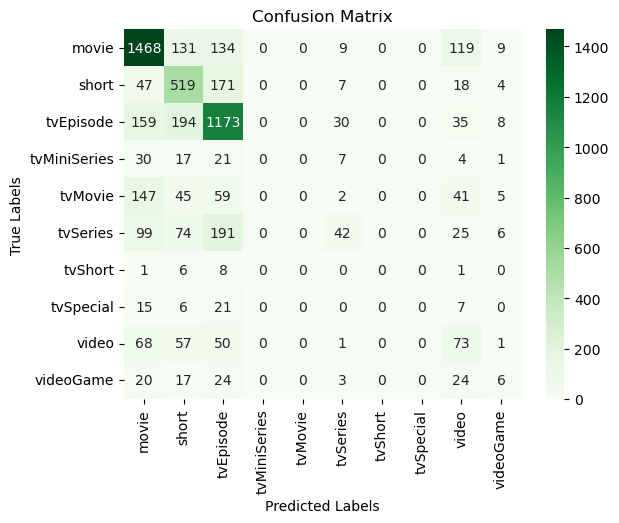

In [15]:
# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

# 10. Visualizzazione della Confusion Matrix

sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
#plt.savefig('categorical_titleType.png', dpi=300, bbox_inches='tight')
plt.show()
